<a href="https://colab.research.google.com/github/abuwildanm/Spotify-Music-Analysis/blob/master/Spotify_Music_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spotify Music Analysis: Discovering Genres using Clustering Methods

---



## Import Libraries and Tools

In [0]:
# Import standard library
import numpy as np
import pandas as pd

# Import statistic library
from scipy.stats import kruskal, chi2_contingency, chi2
from statsmodels.multivariate.manova import MANOVA

# Import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Import visualization library
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import cufflinks as cf
cf.go_offline()

import IPython
# Plotly Configuration
# Ref : https://stackoverflow.com/questions/47230817/plotly-notebook-mode-with-google-colaboratory
def configure_plotly_browser_state():
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))
IPython.get_ipython().events.register('pre_run_cell', configure_plotly_browser_state)

# Spark Configuration
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Enable Arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [0]:
# df = pd.read_csv('data.csv')
df = pd.read_csv('https://docs.google.com/spreadsheets/d/1k3kRJqE5vRPqIs_vhnEl-bBvjQ0Rw2QBlNuDBQLwuWk/export?format=csv')

## Definition of Features
Taken from Spotify's site: https://developer.spotify.com/web-api/get-audio-features/


---


- **acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
- **danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
- **duration_ms**: The duration of the track in milliseconds.
- **energy** is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
- **instrumentalness**: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
- **key**: 	The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
- **liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
- **loudness**: 	The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.
- **mode**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
- **speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
- **tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. The value here is normalized so the max value = 1
- **time_signature**: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).
- **valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).


In [0]:
df.head()

acousticness  danceability  ...      song_title            artist
0        0.0102         0.833  ...        Mask Off            Future
1        0.1990         0.743  ...         Redbone  Childish Gambino
2        0.0344         0.838  ...    Xanny Family            Future
3        0.6040         0.494  ...  Master Of None       Beach House
4        0.1800         0.678  ...  Parallel Lines       Junior Boys

[5 rows x 16 columns]

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 16 columns):
acousticness        2017 non-null float64
danceability        2017 non-null float64
duration_ms         2017 non-null int64
energy              2017 non-null float64
instrumentalness    2017 non-null float64
key                 2017 non-null int64
liveness            2017 non-null float64
loudness            2017 non-null float64
mode                2017 non-null int64
speechiness         2017 non-null float64
tempo               2017 non-null float64
time_signature      2017 non-null int64
valence             2017 non-null float64
target              2017 non-null int64
song_title          2017 non-null object
artist              2017 non-null object
dtypes: float64(9), int64(5), object(2)
memory usage: 252.2+ KB


In [0]:
df.describe()

acousticness  danceability  ...      valence       target
count   2017.000000   2017.000000  ...  2017.000000  2017.000000
mean       0.187590      0.618422  ...     0.496815     0.505702
std        0.259989      0.161029  ...     0.247195     0.500091
min        0.000003      0.122000  ...     0.034800     0.000000
25%        0.009630      0.514000  ...     0.295000     0.000000
50%        0.063300      0.631000  ...     0.492000     1.000000
75%        0.265000      0.738000  ...     0.691000     1.000000
max        0.995000      0.984000  ...     0.992000     1.000000

[8 rows x 14 columns]

In [0]:
drop_cols = ['duration_ms', 'target']
df.drop(drop_cols, axis=1, inplace=True)

In [0]:
nominal_variable = ['key', 'mode', 'time_signature', 'song_title', 'artist']
numeric_variable = df.columns.difference(nominal_variable)

In [0]:
df_numeric = df[numeric_variable]

## Exploratory Data Analysis

### Duplication Check

In [0]:
df[df.duplicated(keep=False)]

acousticness  ...          artist
0         0.010200  ...          Future
148       0.096200  ...           Ibeyi
172       0.024600  ...    Matthew Dear
267       0.096200  ...           Ibeyi
421       0.119000  ...  Kendrick Lamar
480       0.036900  ...     Beach House
508       0.024600  ...    Matthew Dear
714       0.000334  ...          Breach
854       0.934000  ...   John Williams
894       0.000334  ...          Breach
927       0.934000  ...   John Williams
965       0.037800  ...       Daft Punk
981       0.036900  ...     Beach House
1173      0.010200  ...          Future
1215      0.037800  ...       Daft Punk
1226      0.119000  ...  Kendrick Lamar

[16 rows x 14 columns]

In [0]:
df.drop_duplicates(inplace=True)

### Distribution of Data

In [0]:
df.iplot(kind='hist', subplots=True, title='Distribution of Data')

In [0]:
top_artist = df['artist'].value_counts().nlargest(10)
top_artist.iplot(kind='bar', title='Top Artist')

In [0]:
# drop_features = ['instrumentalness']
# df.drop(drop_features, axis=1, inplace=True)
# df_numeric.drop(drop_features, axis=1, inplace=True)

### Skewness Check

In [0]:
print('\nMean:\n', df_numeric.mean())
print('\nMedian:\n', df_numeric.median())
print('\nMode:\n', df_numeric.mode().loc[0])


Mean:
 acousticness          0.187590
danceability          0.618422
energy                0.681577
instrumentalness      0.133286
liveness              0.190844
loudness             -7.085624
speechiness           0.092664
tempo               121.603272
valence               0.496815
dtype: float64

Median:
 acousticness          0.063300
danceability          0.631000
energy                0.715000
instrumentalness      0.000076
liveness              0.127000
loudness             -6.248000
speechiness           0.054900
tempo               121.427000
valence               0.492000
dtype: float64

Mode:
 acousticness         0.1190
danceability         0.6830
energy               0.8570
instrumentalness     0.0000
liveness             0.1010
loudness            -5.3790
speechiness          0.0378
tempo               99.9950
valence              0.1600
Name: 0, dtype: float64


In [0]:
df_numeric.skew()

acousticness        1.658393
danceability       -0.419610
energy             -0.913010
instrumentalness    1.952755
liveness            1.952703
loudness           -2.226556
speechiness         2.309581
tempo               0.439058
valence             0.078390
dtype: float64

### Correlation Check

In [0]:
corr = df.corr()

hm = go.Heatmap(z=corr, x=corr.index, y=corr.columns, colorscale='RdBu', reversescale=True)
layout = go.Layout(title='Correlation Heatmap')
fig = go.Figure(data=hm, layout=layout)
fig.show()

### Outlier Detection

In [0]:
df.iplot(kind='box', title='Outlier Detection')

## Feature Scaling

In [0]:
mms = MinMaxScaler()
mms_df = mms.fit_transform(df_numeric)
mms_df = pd.DataFrame(data=mms_df, columns=df_numeric.columns)

In [0]:
mms_df.iplot(kind='hist', subplots=True, title='Min-Max Distribution')

In [0]:
ss = StandardScaler()
ss_df = ss.fit_transform(df_numeric)
ss_df = pd.DataFrame(ss_df, columns=df_numeric.columns)

In [0]:
ss_df.iplot(kind='hist', subplots=True, title='Z-Transform Distribution')

In [0]:
pt = PowerTransformer()
pt_df = pt.fit_transform(df_numeric)
pt_df = pd.DataFrame(data=pt_df, columns=df_numeric.columns)

In [0]:
pt_df.iplot(kind='hist', subplots=True, title='Yeo-Johnson Distribution')

In [0]:
data = mms_df.copy()
# data = scaled_df.copy()
# data = pt_df.copy()

Dari ketiga metode di atas, yang paling bagus adalah metode Min-Max

## Build the Model

In [0]:
def produceKMeans(k, data):
    global clusterer, preds, centers
    
    # Apply k-means to the data 
    clusterer = KMeans(n_clusters=k, random_state=0)
    clusterer.fit(data)

    # Predict the cluster for each data point
    preds = clusterer.predict(data)

    # Find the cluster centers
    centers = clusterer.cluster_centers_

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(data,preds)
    return score

In [0]:
# # Display the centers
# clusters = ['Cluster {}'.format(i) for i in range(1,len(centers)+1)]
# true_centers = pd.DataFrame(centers, columns = numeric_variable)
# true_centers.index = clusters
# true_centers

In [0]:
# For evaluation
results = pd.DataFrame(columns=['Silhouette Score'])
results.columns.name = 'Number of Clusters'    
for k in range(2,10):
    score = produceKMeans(k, data) 
    results = results.append(pd.DataFrame([score],columns=['Silhouette Score'],index=[k]))

results

Number of Clusters  Silhouette Score
2                           0.354208
3                           0.335806
4                           0.217615
5                           0.222515
6                           0.195513
7                           0.191229
8                           0.191023
9                           0.183522

In [0]:
produceKMeans(2, data)
centers

array([[0.10510118, 0.59459433, 0.73213567, 0.11230722, 0.18826466,
        0.81820497, 0.09635912, 0.43716868, 0.512627  ],
       [0.73299931, 0.45386467, 0.32598665, 0.29485943, 0.13404798,
        0.63055343, 0.03144512, 0.38371284, 0.28719298]])

In [0]:
true_centers = mms.inverse_transform(centers)

# Display the true centers
clusters = ['Cluster {}'.format(i) for i in range(1,len(centers) + 1)]
true_centers = pd.DataFrame(true_centers, columns = data.columns)
true_centers.index = clusters
true_centers

acousticness  danceability  ...       tempo   valence
Cluster 1      0.104578      0.634540  ...  122.821188  0.525487
Cluster 2      0.729335      0.513231  ...  113.655007  0.309701

[2 rows x 9 columns]

In [0]:
# true_centers.drop('tempo', inplace=True, axis=1)

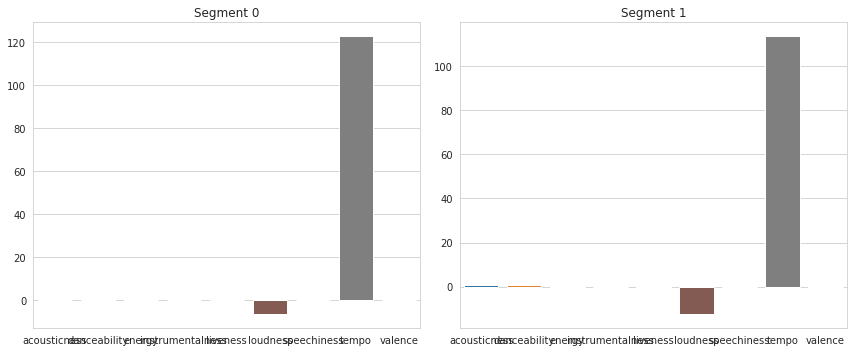

In [0]:
fig, axs = plt.subplots(1, 2, figsize=(12,5), squeeze=False)

axs[0][0].set_title('Segment 0')
sns.barplot(x=true_centers.columns.values,y=true_centers.iloc[0].values, ax = axs[0][0])

axs[0][1].set_title('Segment 1')
sns.barplot(x=true_centers.columns.values,y=true_centers.iloc[1].values, ax = axs[0][1])

plt.tight_layout()

## Using Spark

### Spark Dataframe

In [0]:
sdf = spark.createDataFrame(data)
sdf.show(5)

+--------------------+-------------------+-------------------+--------------------+-------------------+------------------+--------------------+-------------------+-------------------+
|        acousticness|       danceability|             energy|    instrumentalness|           liveness|          loudness|         speechiness|              tempo|            valence|
+--------------------+-------------------+-------------------+--------------------+-------------------+------------------+--------------------+-------------------+-------------------+
|0.010248431261854055| 0.8248259860788861| 0.4263628966639544|0.022438524590163933| 0.1538623447695222|0.7411405916437938|  0.5144406608651785|  0.596033171596529|0.26243209360635195|
| 0.19999771657639703| 0.7204176334106727|0.35008136696501213|0.006260245901639344|0.12439486423910752|0.6921622445867641| 0.07100517089166353| 0.6544741998693666| 0.5779356456330965|
|0.034570108722722384| 0.8306264501160091|  0.403986981285598|2.397540983606557E

In [0]:
from pyspark.ml.feature import VectorAssembler

# Create features column
vecAssembler = VectorAssembler(inputCols=sdf.columns, outputCol='features')
sdf_kmeans = vecAssembler.transform(sdf)
sdf_gmm = vecAssembler.transform(sdf)

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Trains a k-means model.
kmeans = KMeans(k=2)
model = kmeans.fit(sdf_kmeans)

# Make predictions
predictions = model.transform(sdf_kmeans)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print('Silhouette with squared euclidean distance = ' + str(silhouette))

Silhouette with squared euclidean distance = 0.5472939976861734


In [0]:
from pyspark.ml.clustering import GaussianMixture

# Trains a GMM model
gmm = GaussianMixture(k=2)
model = gmm.fit(sdf_gmm)

# Make predictions
predictions = model.transform(sdf_gmm)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print('Silhouette with squared euclidean distance = ' + str(silhouette))

Silhouette with squared euclidean distance = 0.06252649632147281


### Spark RDD

In [0]:
sdf.rdd.take(5)

[Row(acousticness=0.010248431261854055, danceability=0.8248259860788861, energy=0.4263628966639544, instrumentalness=0.022438524590163933, liveness=0.1538623447695222, loudness=0.7411405916437938, speechiness=0.5144406608651785, tempo=0.596033171596529, valence=0.26243209360635195),
 Row(acousticness=0.19999771657639703, danceability=0.7204176334106727, energy=0.35008136696501213, instrumentalness=0.006260245901639344, liveness=0.12439486423910752, loudness=0.6921622445867641, speechiness=0.07100517089166353, tempo=0.6544741998693666, valence=0.5779356456330965),
 Row(acousticness=0.034570108722722384, danceability=0.8306264501160091, energy=0.403986981285598, instrumentalness=0.0002397540983606557, liveness=0.14754788465586194, loudness=0.7913693199146081, speechiness=0.33535124227519236, tempo=0.15853900345245875, valence=0.14437944003343087),
 Row(acousticness=0.6070340542479538, danceability=0.43155452436194885, energy=0.32872253864930834, instrumentalness=0.5225409836065573, liven

In [0]:
data_rdd = sdf.rdd.map(lambda col: np.array(col[:]))

In [0]:
class KMeansRDD():
    
    def __init__(self, n_cluster=4, max_iter=100, tresh=.000001):
        self.n_cluster = n_cluster
        self.max_iter = max_iter
        self.tresh = tresh
        self.centroid = list()
        
    
    def fit(self, data):

        n = 0
        err = float('+inf')
        self.centroid = data.take(self.n_cluster)

        
        def closest_dist(x, cen):
            best_idx = 0
            best_dist = float('+inf')
            for idx in range(len(cen)):
                dist = np.sum((x - cen[idx])**2)**.5
                if dist < best_dist:
                    best_dist = dist
                    best_idx = idx
            return best_idx
    
    
        while(True):
            closest = data.map(lambda x: (closest_dist(x, self.centroid), (x, 1)))
            
            detail_cluster = closest.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
            
            new_centroid = detail_cluster.map(lambda x: x[1][0]/x[1][1]).collect()
            err = np.sum([(new_centroid[i]-self.centroid[i])**2 for i in range(self.n_cluster)])
            if((err < self.tresh) or (n >= self.max_iter)):
                break
            self.centroid = new_centroid
            n += 1
        
        result = closest.map(lambda x: (x[0], x[1][0])).collect()
        
        result_norm = list(map(lambda x: [x[0], list(x[1])], result))
        
        x = [x[1] for x in result_norm]
        y = [x[0] for x in result_norm]
        
        return (x, y)
       

    def predict(self, test):
        
        def closest_dist(x, cen = self.centroid):
            best_idx = 0
            best_dist = float('+inf')
            for idx in range(len(cen)):
                dist = np.sum((x - cen[idx])**2)**.5
                if dist < best_dist:
                    best_dist = dist
                    best_idx = idx
            return best_idx
        
        if isinstance(test, pyspark.rdd.PipelinedRDD):
            closest = test.map(lambda x: closest_dist(x, self.centroid)).collect()
            print(closest)
        
        elif isinstance(test, list):
            closest = [closest_dist(x, self.centroid) for x in test]
            print(closest)
            
        else:
            print('Only can use RDD type and 2 dimension of list type.')
            

    def cluster_center(self):
        if self.centroid == []:
            print('{}\nLakukan proses training terlebih dahulu'.format(self.centroid))
        else:
            for i in range(self.n_cluster):
                print('Cluster {} = {}'.format(i+1, self.centroid[i]))

In [0]:
model = KMeansRDD(n_cluster=2, max_iter=1000)
x, y = model.fit(data_rdd)
silhouette_score(x, y)

0.3542084535212586

## Evaluation

In [0]:
# For evaluation
results = pd.DataFrame(columns=['Silhouette Score'])
results.columns.name = 'Number of Clusters'    
for k in range(2,10):
    # Trains a k-means model.
    kmeans = KMeans(k=k)
    model = kmeans.fit(sdf_kmeans)

    # Make predictions
    predictions = model.transform(sdf_kmeans)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)

    results = results.append(pd.DataFrame([silhouette],columns=['Silhouette Score'],index=[k]))

results

Number of Clusters  Silhouette Score
2                           0.547294
3                           0.296260
4                           0.354918
5                           0.335823
6                           0.320754
7                           0.274056
8                           0.294829
9                           0.285379

In [0]:
# For evaluation
results = pd.DataFrame(columns=['Silhouette Score'])
results.columns.name = 'Number of Clusters'    
for k in range(2,10):
    # Trains a GMM model
    gmm = GaussianMixture(k=k)
    model = gmm.fit(sdf_gmm)

    # Make predictions
    predictions = model.transform(sdf_gmm)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)

    results = results.append(pd.DataFrame([silhouette],columns=['Silhouette Score'],index=[k]))

results

Number of Clusters  Silhouette Score
2                           0.062526
3                           0.046901
4                           0.019403
5                          -0.100902
6                          -0.012403
7                          -0.030468
8                          -0.029143
9                          -0.019514

## Conclusion